# VeloceReduction -- Tutorial

This tutorial provides an example on how to reduce data of a given night YYMMDD.

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
from astropy.io import fits
from pathlib import Path
import sys
import argparse

import matplotlib.pyplot as plt

# VeloceReduction modules and function
from VeloceReduction import config
import VeloceReduction as VR

from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from VeloceReduction.utils import polynomial_function

## Adjust Date and Directory (possibly via argument parser)

In [2]:
def parse_arguments():
    # Create the parser
    parser = argparse.ArgumentParser(description="Process some inputs.")
    
    # Add arguments
    parser.add_argument('-d','--date', type=str, default="001122",
                        help='Date in the format DDMMYY (e.g., "001122")')
    parser.add_argument('-wd','--working_directory', type=str, default="./",
                        help='The directory where the script will operate.')
    
    # Parse the arguments
    args = parser.parse_args()
    return args

def get_script_input():
    if 'ipykernel' in sys.modules:
        
        # Assume default values if inside Jupyter
        jupyter_date = "001122"
        
        # 2Amp example
#         jupyter_date = "240219"
        
        # 4Amp example
#         jupyter_date = "231121"
        
#         jupyter_date = "240201"
        
        jupyter_working_directory = "./"
        print("Running in a Jupyter notebook. Using predefined values")
        args = argparse.Namespace(date=jupyter_date, working_directory=jupyter_working_directory)
    else:
        # Use argparse to handle command-line arguments
        print("Running as a standalone Python script")
        args = parse_arguments()

    return args

# Use the function to get input
args = get_script_input()
config.date = args.date
config.working_directory = args.working_directory
print(f"Date: {args.date}, Working Directory: {args.working_directory}")

Running in a Jupyter notebook. Using predefined values
Date: 001122, Working Directory: ./


## Identfiy Calibration and Science Runs

In [3]:
# Extract the Calibration and Science data from the night log
calibration_runs, science_runs = VR.utils.identify_calibration_and_science_runs(config.date, config.working_directory+'observations/')



Identifying calibration and science runs now

Found Log file ./observations//001122/001122-AAT-example.log


No Bstar observations were identified.

The following science observations were identified: HIP69673


## Extract orders and save in initial FITS files with an extension per order.

In [4]:
# Extract order ranges and coefficients
order_ranges, order_beginning_coeffs, order_ending_coeffs = VR.extraction.read_in_order_tramlines()

In [5]:
# # Extract Master Flat
# print('Extracting Master Flat')
# master_flat, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['Flat_60.0'][:1],
#     ccd2_runs = calibration_runs['Flat_1.0'][:1],
#     ccd3_runs = calibration_runs['Flat_0.1'][:1],
#     Flat = True,
#     update_tramlines_based_on_flat = False, # Would update and overwrite
#     # ./VeloceReduction/tramline_information/tramline_begin_end_ccd_*_oder_*.txt
#     debug_overscan = False,
#     debug_tramlines = False # Would create a tramlines trace PDF under
#     # ./VeloceReduction/tramline_information/debug_tramlines_flat.pdf
# )

# # Extract Master ThXe
# print('Extracting Master ThXe')
# master_thxe, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['FibTh_180.0'][:1],
#     ccd2_runs = calibration_runs['FibTh_60.0'][:1],
#     ccd3_runs = calibration_runs['FibTh_15.0'][:1],
#     debug_tramlines = False # Would create a tramlines trace PDF under
#     # ./VeloceReduction/tramline_information/debug_tramlines.pdf
# )

# # Extract Master LC
# print('Extracting Master LC')
# master_lc, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['SimLC'][-1:],
#     ccd2_runs = calibration_runs['SimLC'][-1:],
#     ccd3_runs = calibration_runs['SimLC'][-1:],
#     LC = True,
#     debug_tramlines = False # Would create a tramlines trace PDF under
#     # ./VeloceReduction/tramline_information/debug_tramlines_lc.pdf
# )

In [6]:
# # Extract Science Objects and save them into FITS files under reduced_data/
# for science_object in list(science_runs.keys()):
#     print('Extracting '+science_object)
#     try:
#         science, science_noise, science_header = VR.extraction.extract_orders(
#             ccd1_runs = science_runs[science_object],
#             ccd2_runs = science_runs[science_object],
#             ccd3_runs = science_runs[science_object],
#             Science=True,
#             debug_tramlines = False, # Would create a tramlines trace PDF under
#             # ./VeloceReduction/tramline_information/debug_tramlines_science.pdf
#             debug_overscan=False
#         )

#         # Create a primary HDU and HDU list
#         primary_hdu = fits.PrimaryHDU()
#         header = primary_hdu.header
#         header['OBJECT']             = (science_header['OBJECT'], 'Name of observed object in night log')
#         header['HIERARCH SOURCE_ID'] = (-1,                       'Gaia DR3 source_id')
#         header['HIERARCH TMASS_ID']  = ('HHMMSSSS-DDMMSSS',       'Identifier in 2MASS catalog')
#         header['UTMJD']              = (science_header['UTMJD'],  'Modified Julian Date of observation')
#         header['MEANRA']             = (science_header['MEANRA'], 'Mean Right Ascension of observed object')
#         header['MEANDEC']            = (science_header['MEANDEC'],'Mean Declination of observed object')        
#         header['BARYVEL']            = ('None',                   'Applied barycentric velocity correction')
#         header['VRAD']               = ('None',                   'Radial velocity estimate')
#         header['E_VRAD']             = ('None',                   'Uncertainty of radial velocity estimate')
#         hdul = fits.HDUList([primary_hdu])

#         # Loop over your extension names and corresponding data arrays
#         for ext_index, ext_name in enumerate(order_beginning_coeffs):
#             # Create an ImageHDU object for each extension
            
#             # Apply flat-field calibration to science
#             science[ext_index,:] /= master_flat[ext_index,:]
#             science_noise[ext_index,:] /= master_flat[ext_index,:]
            
#             # Apply rough renormalisation with outlier-robuster 99th percenile of ~middle of order
#             science_99percentile = np.nanpercentile(science[ext_index,1500:2500],q=99)
#             science[ext_index,:] /= science_99percentile
#             science_noise[ext_index,:] /= science_99percentile
            
#             # Define the columns with appropriate formats
#             col1_def = fits.Column(name='wave_vac',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
#             col2_def = fits.Column(name='wave_air',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
#             col3_def = fits.Column(name='science', format='E', array=science[ext_index,:])
#             col4_def = fits.Column(name='science_noise',   format='E', array=science_noise[ext_index,:])
#             col5_def = fits.Column(name='flat',    format='E', array=master_flat[ext_index,:])
#             col6_def = fits.Column(name='thxe',    format='E', array=master_thxe[ext_index,:]/master_flat[ext_index,:])
#             col7_def = fits.Column(name='lc',      format='E', array=master_lc[ext_index,:]/master_flat[ext_index,:])

#             # Combine columns to BinTable and add header from primary
#             hdu = fits.BinTableHDU.from_columns([col1_def, col2_def, col3_def, col4_def, col5_def, col6_def, col7_def], name=ext_name.lower())
#             hdu.header.extend(header.copy(strip=True), unique=True)
            
#             # Append the HDU to the HDU list
#             hdul.append(hdu)

#         # Save to a new FITS file with an extension for each order
#         Path(config.working_directory+'reduced_data/'+config.date+'/'+science_object).mkdir(parents=True, exist_ok=True)
#         spectrum_filename = 'veloce_spectra_'+science_object+'_'+config.date+'.fits'
#         hdul.writeto(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/'+spectrum_filename, overwrite=True)

#         print('  -> Successfully extracted '+science_object)

#     except:
#         print('  -> Failed to extract '+science_object)

## Wavelength calibration

Calibrating wavelength for HIP69673
  -> Correcting for barycentric velocity: -21.07 km/s
  -> Estimating rough Radial Velocity from Halpha and CaII triplet
  -> Fitting Halpha, but neglecting for RV estimate.
  -> $v_\mathrm{rad}  = -4.6 \pm 0.8 \pm 0.7\,\mathrm{km\,s^{-1}}$ (mean, scatter, uncertainty)


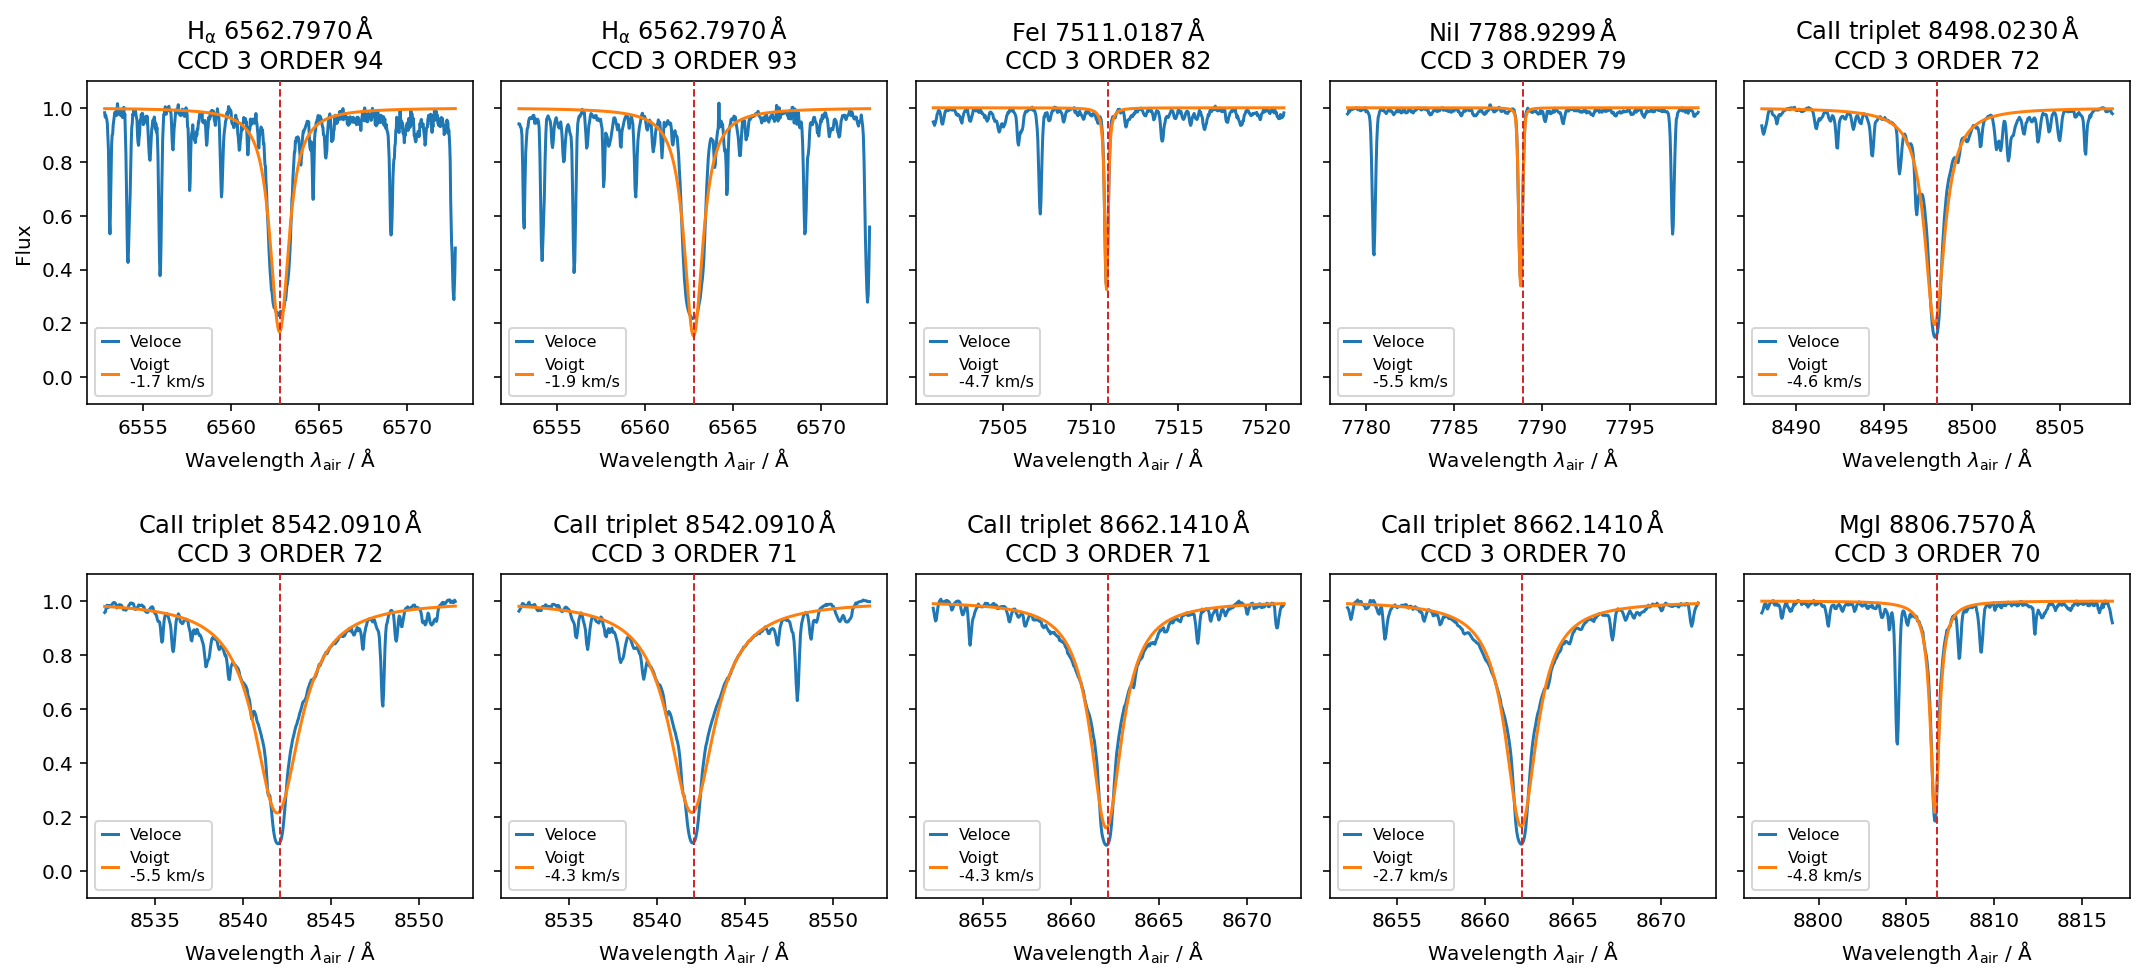

  -> Creating overview PDF. This may take some time for the 109 orders.


In [11]:
for science_object in list(science_runs.keys()):
#     try:
    VR.calibration.calibrate_wavelength(
        science_object,
        correct_barycentric_velocity=True,
        create_overview_pdf=False
    )
#         print('  -> Succesfully calibrated wavelength with diagnostic plots for '+science_object)
#     except:
#         print('  -> Failed to calibrate wavelength for '+science_object)

## DELETE WHEN DONE! LASER COMB

In [8]:
# sys.exit()

In [9]:
science_object = 'HIP69673'
input_output_directory = config.working_directory+'reduced_data/'+config.date+'/'+science_object

spectrum = dict()

with fits.open(input_output_directory+'/veloce_spectra_'+science_object+'_'+config.date+'.fits', mode='update') as file:
    
    for index in range(1,len(file)):

        spectrum[file[index].header['EXTNAME'].lower()] = Table()
        for key in ['wave_vac','wave_air','science','science_noise','flat','thxe','lc']:
            spectrum[file[index].header['EXTNAME'].lower()][key] = file[index].data[key]
            
coeffs_tinney = VR.utils.read_in_wavelength_solution_coefficients_tinney()


1455 3900


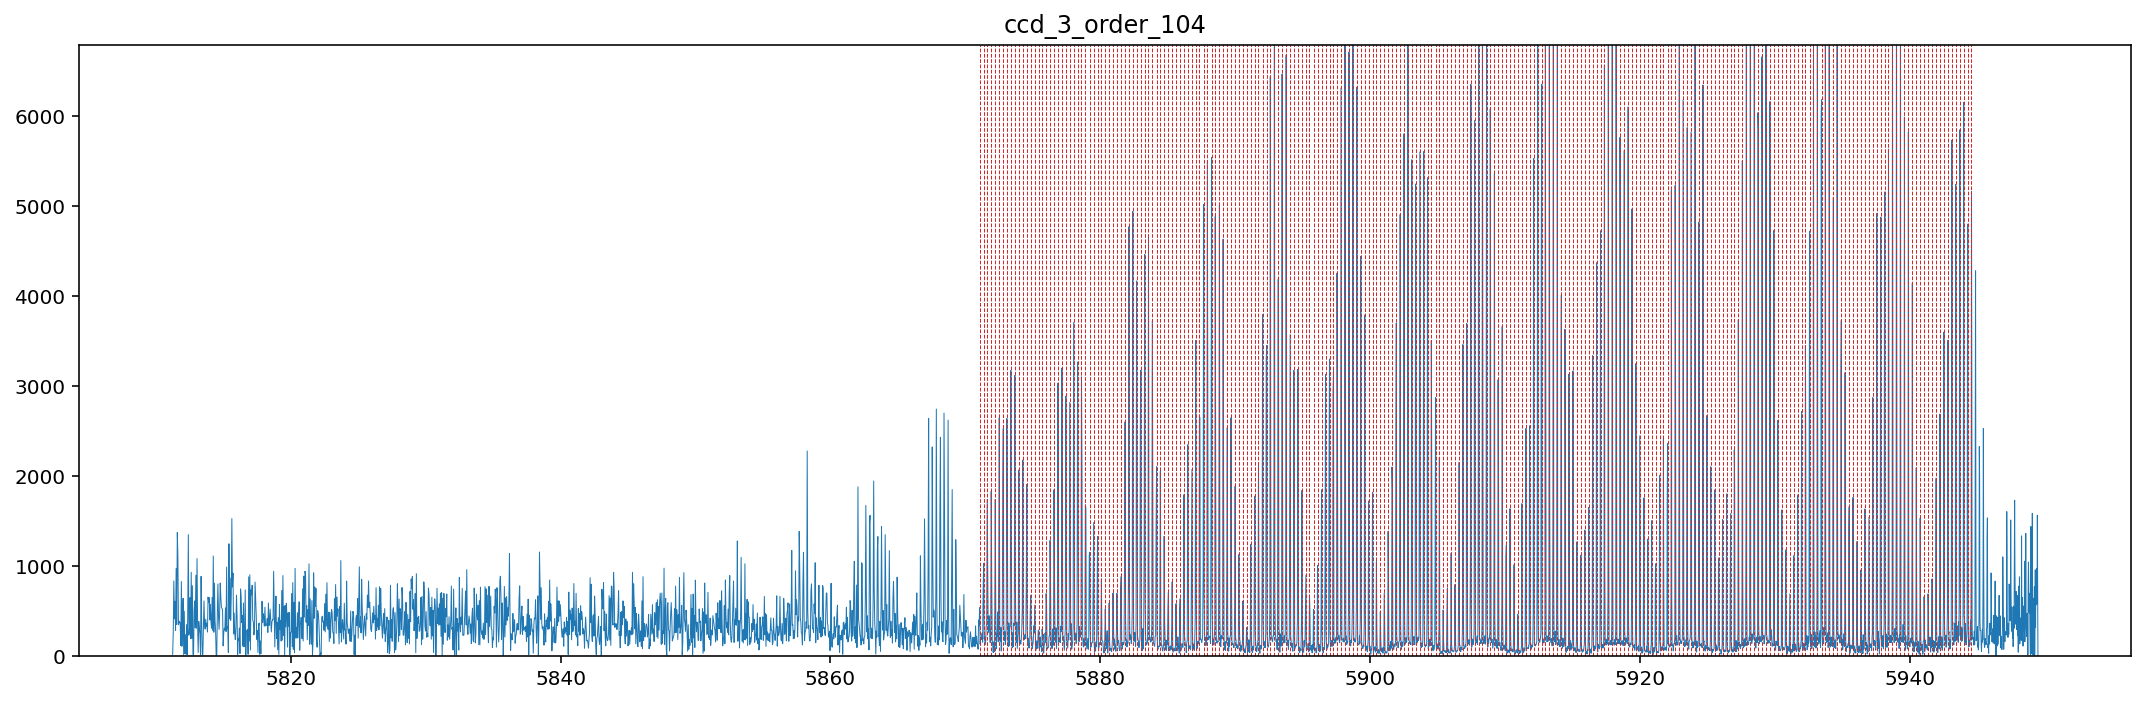

peaks:  253
modes:  253
0th and 4128th pixel:
[581.06633298 594.99837643]
[ 5.89267773e+02  3.34269605e-03 -2.86939116e-07  8.19344104e-12
 -7.17975696e-16 -1.42732446e-19]


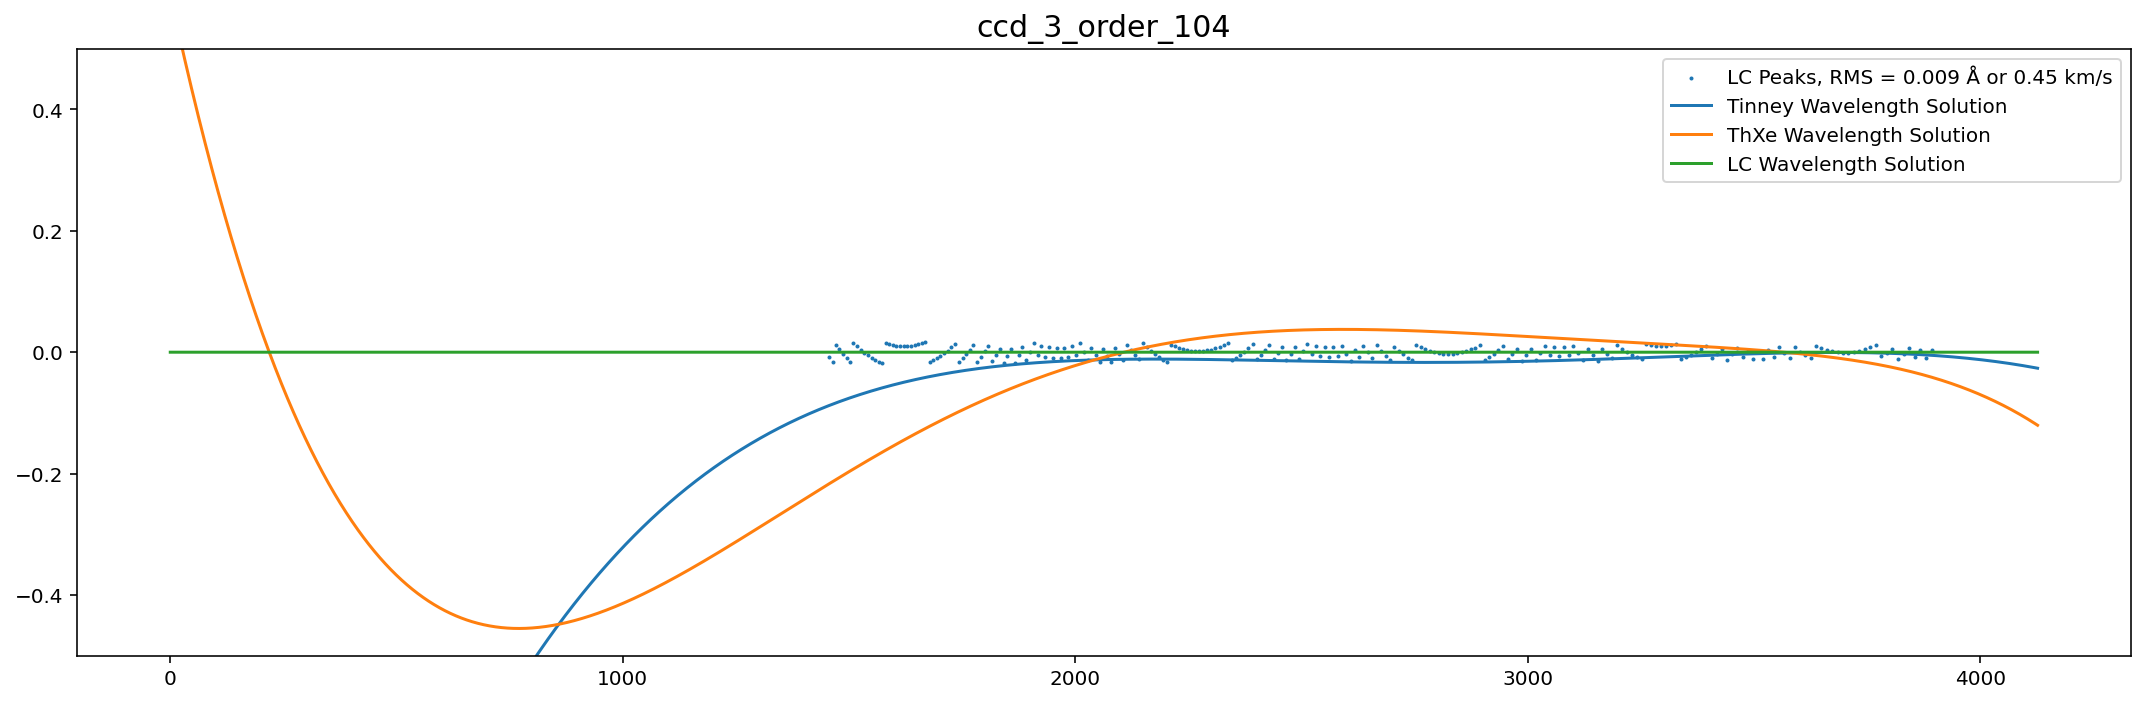

In [10]:
lc_range = dict()
lc_range['ccd_3_order_104'] = [1455,3900]
lc_range['ccd_3_order_103'] = [780,3900]
lc_range['ccd_3_order_102'] = [700,3900]
lc_range['ccd_3_order_101'] = [650,3920]
lc_range['ccd_3_order_100'] = [600,3925]
lc_range['ccd_3_order_99'] = [490,3925]
lc_range['ccd_3_order_98'] = [500,3925]
lc_range['ccd_3_order_97'] = [325,3825]
lc_range['ccd_3_order_96'] = [255,3850]
lc_range['ccd_3_order_95'] = [250,3650]
lc_range['ccd_3_order_94'] = [450,3800]
lc_range['ccd_3_order_93'] = [270,3700]
lc_range['ccd_3_order_92'] = [540,2800]
lc_range['ccd_3_order_91'] = [630,3525]
lc_range['ccd_3_order_90'] = [490,3525]
lc_range['ccd_3_order_89'] = [355,3465]
lc_range['ccd_3_order_88'] = [400,2900]
lc_range['ccd_3_order_87'] = [400,3250]
lc_range['ccd_3_order_86'] = [200,3200]
lc_range['ccd_3_order_85'] = [455,3655]
lc_range['ccd_3_order_84'] = [150,3578]
lc_range['ccd_3_order_83'] = [145,3850]
lc_range['ccd_3_order_82'] = [120,3870]
lc_range['ccd_3_order_81'] = [125,4050]
lc_range['ccd_3_order_80'] = [130,4000]
lc_range['ccd_3_order_79'] = [120,4070]
lc_range['ccd_3_order_78'] = [100,4100]
lc_range['ccd_3_order_77'] = [100,4100]
lc_range['ccd_3_order_76'] = [105,4095]
lc_range['ccd_3_order_75'] = [99,4050]
lc_range['ccd_3_order_74'] = [745,4050]
lc_range['ccd_3_order_73'] = [99,4100]
lc_range['ccd_3_order_72'] = [99,4110]
lc_range['ccd_3_order_71'] = [95,4086]
lc_range['ccd_3_order_70'] = [90,4087]
lc_range['ccd_3_order_69'] = [90,4087]
lc_range['ccd_3_order_68'] = [90,4090]
lc_range['ccd_3_order_67'] = [100,4090]
lc_range['ccd_3_order_66'] = [100,3730]

# lc_range = dict()

# lc_range['ccd_3_order_104'] = [1455,3900]

orders = ['ccd_3_order_104']

use_ylim = True
overwrite = True

# for order in list(spectrum.keys()):
# for order in lc_range.keys(): 
for order in orders: 
    
    if (order[4] != '1') & (order != 'ccd_3_order_65'):

        thxe_file_path = './VeloceReduction/veloce_reference_data/thxe_pixels_and_positions/' + order + '_px_wl.txt'
        thxe_pixels_and_wavelengths = np.array(np.loadtxt(thxe_file_path))

        # Fit a polynomial function to pixel and wavelength data
        coeffs_thxe, _ = curve_fit(
            polynomial_function,
            thxe_pixels_and_wavelengths[:,0] - 2064,
            thxe_pixels_and_wavelengths[:,1],
            p0=[np.median(thxe_pixels_and_wavelengths[:,1]), 0.05, 0.0, 0.0, 0.0, 0.0]
        )
        
        if order in lc_range.keys():
            lc_beginning, lc_ending = lc_range[order]
        else:
            lc_beginning = 100
            lc_ending = 4000
            
        print(lc_beginning,lc_ending)

        # Plot LC positions  
        wavelength = spectrum[order]['wave_vac']
        wavelength = polynomial_function(np.arange(4128)-2064,*coeffs_thxe)*10

        f, ax = plt.subplots(1,1,figsize=(15,5))

        ax.set_title(order)

        in_panel = np.arange(lc_beginning,lc_ending+1)

        ax.plot(
            wavelength,
            spectrum[order]['lc'],
            lw = 0.5
        )
        ax.set_ylim(0,1.1*np.nanpercentile(spectrum[order]['lc'],q=99))

        peaks, peak_metadata = find_peaks(
            spectrum[order]['lc'][in_panel],
            height = 2,
            prominence = 2,
            distance = 7
        )

        for peak in peaks:
            ax.axvline(wavelength[in_panel][peak], c = 'C3', lw=0.5, ls='dashed')

        plt.tight_layout()
        plt.show()
        plt.close()

        lc_number_upper = np.floor(VR.utils.lasercomb_numbers_from_wavelength(wavelength[in_panel][0]))
        lc_number_lower = np.ceil(VR.utils.lasercomb_numbers_from_wavelength(wavelength[in_panel][-1]))
        lc_wavelengths = VR.utils.lasercomb_wavelength_from_numbers(np.arange(lc_number_lower, lc_number_upper+1))[::-1]

        print('peaks: ',len(peaks))
        print('modes: ',len(lc_wavelengths))
        
        if len(peaks) != len(lc_wavelengths):
            use_peaks_and_modes = np.min([len(peaks),len(lc_wavelengths)])
            print('Only using first '+str(use_peaks_and_modes)+' entries')
        else:
            use_peaks_and_modes = len(peaks)

        # for lc_wavelength in lc_wavelengths:
        #     ax.axvline(lc_wavelength, c = 'C1', lw = 0.5, ls='dashed')

        # Fit a polynomial function to pixel and wavelength data
        coeffs_lc, _ = curve_fit(
            polynomial_function,
            lc_beginning + peaks[:use_peaks_and_modes] - 2064,
            lc_wavelengths[:use_peaks_and_modes]/10.,
            p0=[np.median(lc_wavelengths), 0.05, 0.0, 0.0, 0.0, 0.0]
        )

        print('0th and 4128th pixel:')
        print(polynomial_function(np.array([0,4128])-2064,*coeffs_lc))
        
        print(coeffs_lc)
        
        if overwrite:
            np.savetxt('./VeloceReduction/wavelength_coefficients/wavelength_coefficients_'+order+'.txt',coeffs_lc)

        rms_wavelength = np.std(lc_wavelengths[:use_peaks_and_modes] - (polynomial_function(lc_beginning+peaks[:use_peaks_and_modes]-2064,*coeffs_lc)*10))
        rms_velocity = 299792.46 * np.std((lc_wavelengths[:use_peaks_and_modes] - (polynomial_function(lc_beginning+peaks[:use_peaks_and_modes]-2064,*coeffs_lc)*10))/lc_wavelengths[:use_peaks_and_modes])

        plt.figure(figsize=(15,5))
        plt.title(order,fontsize=15)
        
        plt.scatter(
            lc_beginning+peaks[:use_peaks_and_modes],
            lc_wavelengths[:use_peaks_and_modes] - (polynomial_function(lc_beginning+peaks[:use_peaks_and_modes]-2064,*coeffs_lc)*10),
            s = 1,
            label = 'LC Peaks, RMS = '+str(np.round(rms_wavelength,3))+' Å or '+str(np.round(rms_velocity,2))+' km/s'
        )
        
        
        plt.plot(
            np.arange(4128),
            polynomial_function(np.arange(4128)-2450-3,*coeffs_tinney[order][:-1])*10 -
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10,
            label = 'Tinney Wavelength Solution'
        )
        plt.plot(
            np.arange(4128),
            polynomial_function(np.arange(4128)-2064,*coeffs_thxe)*10 - 
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10,
            label = 'ThXe Wavelength Solution'
        )
        plt.plot(
            np.arange(4128),
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10 - 
            polynomial_function(np.arange(4128)-2064,*coeffs_lc)*10,
            label = 'LC Wavelength Solution'
        )
        if use_ylim:
            plt.ylim(-0.5,0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()